Loading energy data...
✅ Data loaded successfully!

Creating features for anomaly detection...
✅ Data loaded successfully!

Creating features for anomaly detection...


/tmp/ipykernel_3618/1308985939.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_3618/1308985939.py:46: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  energy_df['pct_change'] = energy_df.groupby('CONS_NO')['consumption'].transform('pct_change').fillna(0)
/tmp/ipykernel_3618/1308985939.py:46: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  energy_df['pct_change'] = energy_df.groupby('CONS_NO')['consumption'].transform('pct_change


Checking for infinities or NaNs in features:
consumption       0
rolling_mean_3    0
rolling_std_3     0
pct_change        0
lag_1             0
lag_2             0
z_score           0
dtype: int64

Feature ranges:
     consumption  rolling_mean_3  rolling_std_3  pct_change      lag_1  \
min         0.00        0.000000       0.000000        -1.0       0.00   
max    514991.78   171663.926667  297330.642813         1.0  514991.78   

       lag_2   z_score  
min      0.0 -4.902903  
max  92713.9  4.902903  

Training Isolation Forest model...

Consumers with highest anomaly percentages:
                            CONS_NO  predicted_anomaly  anomaly_percentage
0  0000E78A22CB04533A0D9E1F2FBEEC5D                  0                 NaN
1  0002D8E9C198E4A2B03BFA6D1E2E1B6D                  0                 NaN
2  000395F84A94D4CB2E5D4D77372CFB4D                  0                 NaN
3  000E6116D092E1C94AF3EFA5998363B0                  0                 NaN
4  00127DCB5EB56E6D3C56E88CE58

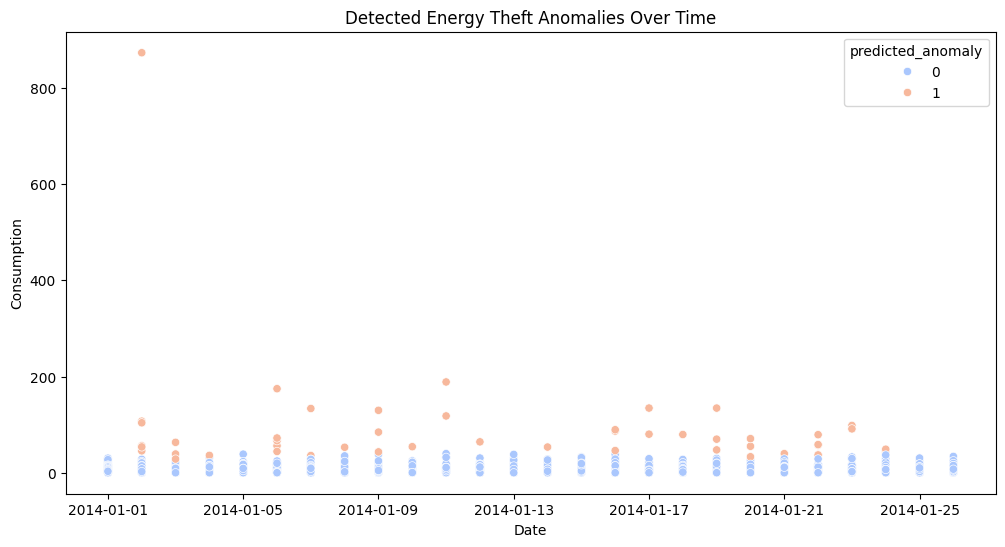

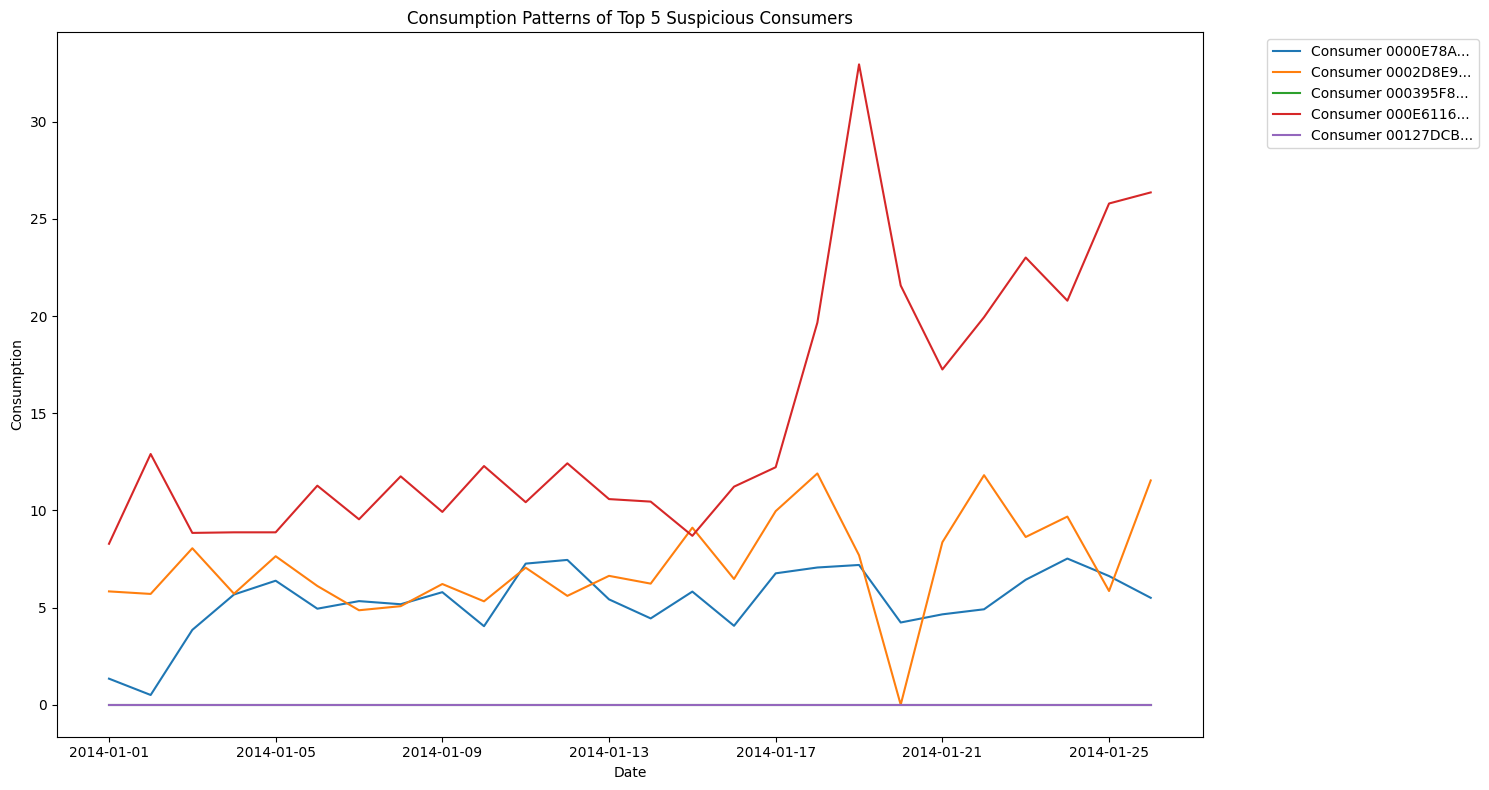


💾 Model saved to: /var/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/data/energy_model.joblib
💾 Scaler saved to: /var/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/data/energy_scaler.joblib
💾 Results saved to: /var/home/kiddomendes/Documents/GitHub/VUT/energy_theft_and_oil_leak/data/energy_theft_results.csv

✅ Analysis complete!


In [5]:
# 04_model_energy_theft.ipynb
# AI Model for Energy Theft Detection

# ---------------------------------------------------
# 1️⃣ Import Libraries
# ---------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

# ---------------------------------------------------
# 2️⃣ Load and Prepare Data
# ---------------------------------------------------
DATA_DIR = Path.cwd().parent / 'data'
energy_path = DATA_DIR / 'energy_data_transformed.csv'

print("Loading energy data...")
energy_df = pd.read_csv(energy_path)
energy_df['date'] = pd.to_datetime(energy_df['date'])
print("✅ Data loaded successfully!")

# ---------------------------------------------------
# 3️⃣ Create Features
# ---------------------------------------------------
print("\nCreating features for anomaly detection...")

# Sort by consumer and date to ensure correct feature calculation
energy_df = energy_df.sort_values(['CONS_NO', 'date']).reset_index(drop=True)

# Rolling statistics (with handling for edge cases)
energy_df['rolling_mean_3'] = energy_df.groupby('CONS_NO')['consumption'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
).fillna(method='bfill').fillna(method='ffill')

energy_df['rolling_std_3'] = energy_df.groupby('CONS_NO')['consumption'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
).fillna(0)  # Fill NaN with 0 for std when there's not enough data

# Percentage change (capped at ±100% to handle extreme values)
energy_df['pct_change'] = energy_df.groupby('CONS_NO')['consumption'].transform('pct_change').fillna(0)
energy_df['pct_change'] = energy_df['pct_change'].clip(-1, 1)  # Cap at ±100%

# Lagged values
energy_df['lag_1'] = energy_df.groupby('CONS_NO')['consumption'].transform(
    lambda x: x.shift(1)
).fillna(method='bfill')

energy_df['lag_2'] = energy_df.groupby('CONS_NO')['consumption'].transform(
    lambda x: x.shift(2)
).fillna(method='bfill')

# Z-score within each consumer's data (with handling for edge cases)
def safe_zscore(x):
    std = x.std()
    if std == 0:
        return np.zeros_like(x)
    return (x - x.mean()) / std

energy_df['z_score'] = energy_df.groupby('CONS_NO')['consumption'].transform(safe_zscore)

# Replace any remaining infinities with large finite values
energy_df = energy_df.replace([np.inf, -np.inf], np.nan)
energy_df = energy_df.fillna(method='ffill').fillna(method='bfill')

# ---------------------------------------------------
# 4️⃣ Prepare Data for Modeling
# ---------------------------------------------------
# Select features for anomaly detection
features = ['consumption', 'rolling_mean_3', 'rolling_std_3', 'pct_change', 
           'lag_1', 'lag_2', 'z_score']
X = energy_df[features]

# Verify no infinities or NaNs in the data
print("\nChecking for infinities or NaNs in features:")
print(X.isna().sum())
print("\nFeature ranges:")
print(X.agg(['min', 'max']))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------
# 5️⃣ Train Isolation Forest (unsupervised anomaly detection)
# ---------------------------------------------------
print("\nTraining Isolation Forest model...")
iso_forest = IsolationForest(contamination=0.02, random_state=42)
energy_df['anomaly_score'] = iso_forest.fit_predict(X_scaled)

# Label anomalies: -1 → anomaly, 1 → normal
energy_df['predicted_anomaly'] = energy_df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# ---------------------------------------------------
# 6️⃣ Analyze Results
# ---------------------------------------------------
# Count anomalies per consumer
anomaly_counts = energy_df.groupby('CONS_NO')['predicted_anomaly'].sum().reset_index()
anomaly_counts['anomaly_percentage'] = (anomaly_counts['predicted_anomaly'] / 
                                      energy_df.groupby('CONS_NO').size() * 100)

print("\nConsumers with highest anomaly percentages:")
print(anomaly_counts.sort_values('anomaly_percentage', ascending=False).head())

# ---------------------------------------------------
# 7️⃣ Visualize Anomalies
# ---------------------------------------------------
# Plot overall distribution
plt.figure(figsize=(12, 6))
sns.scatterplot(data=energy_df.sample(3000), x='date', y='consumption', 
                hue='predicted_anomaly', palette='coolwarm')
plt.title('Detected Energy Theft Anomalies Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.show()

# Plot for top 5 suspicious consumers
suspicious_consumers = anomaly_counts.nlargest(5, 'anomaly_percentage')['CONS_NO'].tolist()
plt.figure(figsize=(15, 8))

for consumer in suspicious_consumers:
    consumer_data = energy_df[energy_df['CONS_NO'] == consumer]
    plt.plot(consumer_data['date'], consumer_data['consumption'], 
             label=f'Consumer {consumer[:8]}...')

plt.title('Consumption Patterns of Top 5 Suspicious Consumers')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 8️⃣ Save Results
# ---------------------------------------------------
# Save model and scaler
model_path = DATA_DIR / 'energy_model.joblib'
scaler_path = DATA_DIR / 'energy_scaler.joblib'
joblib.dump(iso_forest, model_path)
joblib.dump(scaler, scaler_path)

# Save results with anomaly detection
results_path = DATA_DIR / 'energy_theft_results.csv'
energy_df.to_csv(results_path, index=False)

print(f"\n💾 Model saved to: {model_path}")
print(f"💾 Scaler saved to: {scaler_path}")
print(f"💾 Results saved to: {results_path}")

print("\n✅ Analysis complete!")